 **Project 3: Classification of Sub-Reddits with NLP**
 ***

# Introduction and Problem Statement

**Sub-reddits:**<br>
[British Problems](https://www.reddit.com/r/britishproblems/) and
[British Success](https://www.reddit.com/r/britishproblems/)

**Context**<br>
You are working for SGAG in Singapore and have been tasked to explore new social media engagement channels via Reddit. Since Singaporeans are known to complain a lot, you are thinking of creating sub-reddits that would encourage users to post about the travails of daily life in humourous ways. 

**Why choose the two sub-reddits?**<br>
You are aware of two sub-reddits from the UK that fit your idea (r/britishproblems and r/BritishSuccess). On the surface, they appear to be distinct topics (complaining about problems vs. celebrating success). However, taken in the context of british humour, they could potentially be quite similar in terms of their linguistic construct. 

To explain, british humour is largely based on sarcasm and satire and is aimed at the absurdity of everyday life. As such, ironic language is often deployed in its execution. Naturally, this means that such humour is highly context-based and could potentially be difficult to distinguish for a non-human reader. For example, in the context of our sub-reddits, consider the statement below:

*'I am excited to be taking a nice stroll in the rain again...'*

Would the machine learning algorithm classify this as a 'success' since you have words associated with positive sentiments (e.g. excited, nice stroll)? The poster - living in wet and cold London - is most likely complaining about having to go out in the rain. 

**Problem Statement**<br>
You are also considering the idea of creating two sub-reddits - *SingaporeanProblems* and *SingaporeanSuccess*. However, you want to avoid the two sub-reddits cannablising viewership from each other in the event that they both end up being very similar. Like British humour, Singlish is also a highly dynamic language form. Therefore, by investigating the differentiating features in the two sub-reddits, you want to find out if humour (especially ironic language) can be differentiated by the model. This will then allow you to decide whether to set up one or two sub-reddits.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

%matplotlib inline

## Functions

In [3]:
def scrape(subreddit):
    '''Function to scrape sub-reddits with Pushshift API'''
    
    #Scrape 1st set of 100 posts
    count = 1
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
    'subreddit': subreddit,
    'size': 100}
    
    res = requests.get(url, params)
    print(f'request: {count}', f'res status: {res.status_code}')
    data = res.json()
    posts = data['data']
    df = pd.DataFrame(posts)
    
    #Scrape until 20 sets of 100 posts
    for i in range(1,20):
        count += 1
        url = 'https://api.pushshift.io/reddit/search/submission'
        params = {'subreddit': subreddit, 
                  'size': 100, 
                  'before': df['created_utc'].min()}
        
        res = requests.get(url, params)
        data = res.json()
        if res.status_code == 200:
            print(f'request: {count}', f'res status: {res.status_code}')
            posts = data['data']
            next_df = pd.DataFrame(posts)
            df = pd.concat([df, next_df], ignore_index=True)
        else:
            response_dict = json.loads(response)
            print(response_dict)
    return df

# Scrape Data from Reddit

For this project, I scrapped 2k posts from each sub-reddit.

Note: These are commented to avoid scraping a new set of data each time the notebook is run

In [4]:
#scrape_problems = scrape('britishproblems')

In [5]:
#scrape_success = scrape('BritishSuccess')

In [6]:
#scrape_problems.to_csv(r'../datasets/scrape_problems.csv', index=False)

In [7]:
#scrape_success.to_csv(r'../datasets/scrape_success.csv', index=False)

# Data Cleaning

## Load Scraped Datasets

In [8]:
problems = pd.read_csv(r'../datasets/scrape_problems.csv')

In [9]:
success = pd.read_csv(r'../datasets/scrape_success.csv')

## Keep Relevant Columns

In [10]:
problems = problems[['id','selftext','title','author','created_utc','score']]

In [11]:
success = success[['id','selftext','title','author','created_utc','score']]

In [12]:
problems.head(5)

,id,selftext,title,author,created_utc,score
0,pu9dd0,[removed],Almost getting spotted throwing the old mattre...,DangersVengeance,1632446675,1
1,pu92vw,NaN,Not realising how bad your area is until you d...,LDNscallywag,1632445623,1
2,pu8m40,[removed],Just dropped my digestive into my tea 😐,Sharny__xx,1632443917,1
3,pu8luo,"Who are all these extra people, and where are ...","Having to drive north up the M6, M62 and M60 o...",BearyConfused,1632443891,1
4,pu8hml,[removed],My mum made me an evening meal,Sedso85,1632443456,1


In [13]:
success.head(5)

,id,selftext,title,author,created_utc,score
0,pu54ti,[removed],Finally figuring out the countdown conundrum b...,TheTjalian,1632432390,1
1,pu4ko8,Guy on a motorbike comes up behind me and trai...,Made a motorbike buddy,Supersoniccyborg,1632430739,1
2,pu4dc2,[removed],Just got a shoutout + my request played on Rad...,AB6Daf,1632430122,1
3,pu24of,[removed],When you step on a 3 pin plug but manage to bu...,jimmycarr1,1632423509,1
4,pu1722,[removed],Only had to buy milk and the person in front h...,SpiderSixer,1632420836,1


## Remove Posts Deleted by Author

Selftext = NaN or [deleted] is the same as author = [deleted]. This means the post has been deleted by the author, and we will drop them from the datasets.

In [14]:
problems.loc[(problems['selftext'] == '[deleted]') | (problems['author'] == '[deleted]'),['selftext','title','author']]

,selftext,title,author
144,[deleted],My local supermarkets are full of Christmas sh...,[deleted]
145,NaN,Waking up at 4 am and unable to fall asleep be...,[deleted]
150,NaN,GP Receptionists,[deleted]
171,[deleted],Suffering the indignity of being called a two-...,[deleted]
821,NaN,People ignoring the main reason we have no tru...,[deleted]
1420,[deleted],Feeling guilty for sitting in front a busker w...,[deleted]
1485,[deleted],When the full contents Six packets of crisps f...,[deleted]
1544,[deleted],Living in a listed building which thieves can ...,[deleted]
1811,NaN,What kind of authoritarian society does the wo...,[deleted]
1933,[deleted],"RyanAir’s undocumented, unreported and unknown...",[deleted]


In [15]:
problems = problems.loc[(problems['author'] != '[deleted]') & (problems['selftext'] != '[deleted]'),:].reset_index(drop=True)

In [16]:
success.loc[(success['selftext'] == '[deleted]') | (success['author'] == '[deleted]'),['selftext','title','author']]

,selftext,title,author
362,[deleted],Just ordered my nursing uniform!,[deleted]
400,[deleted],It's extremely easy to know how bad the pandem...,weazelmafghfgh
796,NaN,Hay-fever not bothering me at all today... bec...,[deleted]
1313,[deleted],Got incredibly expensive hearing aids on the N...,[deleted]
1315,[deleted],Aldi are location scouting for new stores near...,[deleted]
1325,NaN,God entered into my body and my dick got hard,[deleted]
1332,[deleted],Finally got my toddler into a playgroup... and...,[deleted]
1333,[deleted],Just been diagnosed with ADHD at 27.,[deleted]
1346,[deleted],For almost 40 years when I eat my mashed potat...,[deleted]
1356,[deleted],England winning their 1st Euro 2021 match!,[deleted]


In [17]:
success = success.loc[(success['author'] != '[deleted]') & (success['selftext'] != '[deleted]'),:].reset_index(drop=True)

## Remove Posts Removed by Reddit/Moderator

Selftext = [removed] means that the post was removed by moderator/reddit. We will drop these from both datasets.

In [18]:
problems.loc[problems['selftext'] == '[removed]',['selftext','title','author']]

,selftext,title,author
0,[removed],Almost getting spotted throwing the old mattre...,DangersVengeance
2,[removed],Just dropped my digestive into my tea 😐,Sharny__xx
4,[removed],My mum made me an evening meal,Sedso85
5,[removed],Tinder is the Asda of dating apps,Signal_Quality_3865
8,[removed],Northern girl diet has made me fat,Sharny__xx
...,...,...,...
1971,[removed],Waiting at Lidl,TAB20201
1973,[removed],The Monthly Barber Conversation,TheRaven9
1974,[removed],"Roadworks popping up everywhere, populated by ...",RedditHatesMyChoices
1976,[removed],Every day is a 'bank holiday',fort_panda


In [19]:
problems = problems.loc[problems['selftext'] != '[removed]',:].reset_index(drop=True)

In [20]:
success.loc[success['selftext'] == '[removed]',['selftext','title','author']]

,selftext,title,author
0,[removed],Finally figuring out the countdown conundrum b...,TheTjalian
2,[removed],Just got a shoutout + my request played on Rad...,AB6Daf
3,[removed],When you step on a 3 pin plug but manage to bu...,jimmycarr1
4,[removed],Only had to buy milk and the person in front h...,SpiderSixer
7,[removed],Decided to give the new series of Never Mind T...,herumdegumff
...,...,...,...
1817,[removed],Britain vs America,DorathyMinnifield
1818,[removed],Britain vs America,DorathyMinnifield
1888,[removed],What supplements are your favourite and why?,Bill1234550987654321
1905,[removed],Found investment success with Mr. Adam Fayed,WealthMagnet016


In [21]:
success = success.loc[success['selftext'] != '[removed]',:].reset_index(drop=True)

## Remove Any Duplicates

A majority of duplicates would have been removed by Reddit and are marked with the [removed] flag. We have removed them in the previous step. We will now remove any remaining duplicates.

In [22]:
problems.loc[(problems['title'].duplicated()),['title','author']]

,title,author
67,Needing to wear earplugs when you're forced ba...,greenbox1990
254,Being simultaneously too hot and too cold to s...,Prestigious-Ad3867
369,"GWR Twitter, I don’t want a “if you had a rese...",KrozJr_UK
1099,Waiting in a 90 minute queue when trying to ca...,Rengoku-Onigiri


In [23]:
problems = problems.drop_duplicates(subset=['title']).reset_index(drop=True)

In [24]:
success.loc[(success['title'].duplicated()),['title','author']]

,title,author
232,"Overcharged on gas for years, now paying £5pm ...",Chevey0
582,Emma Raducanu,gbhbri20
679,It's raining,jdmstig
1154,Has anyone started doing anything during lockd...,CampMain
1292,Amazon refund success,Historical-Tax-2010


In [25]:
success = success.drop_duplicates(subset=['title']).reset_index(drop=True)

## Remove URLs

There are website/image links in some of the reddit posts. I will use regex to identify and remove them since they will not work with our vectorization/modelling tools.

In [26]:
#This regex should pick out any urls with https / http / wwww and combinations of these

url_regex = r'https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-z-A-Z0-9]+\.[^\s]{2,}'

In [27]:
problems['selftext'].replace(url_regex, ' ', regex=True, inplace=True)

In [28]:
success['selftext'].replace(url_regex, ' ', regex=True, inplace=True)

## Fill NaNs with Empty Strings

The subreddits are predominantly on humour. For comedic effect, a majority of the posts are submitted as 'one-liners' in the title and have nothing in the 'selftext' field. As such, I will be filling the NaNs in the 'selftext' field with empty strings, and subequently combining it with the 'title' field. The new combined field will be named as '**content**'.

In [29]:
problems['selftext'].fillna('', inplace = True)

In [30]:
success['selftext'].fillna('', inplace = True)

## Combine 'selftext' and 'title'

In [31]:
problems['content'] = problems['selftext'] + ' ' + problems['title']
problems.drop(columns=['selftext','title'], inplace=True)

In [32]:
success['content'] = success['selftext'] + ' ' + success['title']
success.drop(columns=['selftext','title'], inplace=True)

## Replace \n \r

In the datasets, there are linebreaks (\n or \r) which I will remove from the 'content' field.

In [33]:
linebreak_regex = r'(\r\n|\r|\n)'

In [34]:
problems['content'].replace(linebreak_regex, ' ', regex=True, inplace=True)

In [35]:
success['content'].replace(linebreak_regex, ' ', regex=True, inplace=True)

## Remove Multiple Whitespace

In [36]:
multiple_whitespace_regex = r'([ ]{2,})'

In [37]:
problems['content'].replace(multiple_whitespace_regex, ' ',regex=True, inplace=True)

In [38]:
success['content'].replace(multiple_whitespace_regex, ' ',regex=True, inplace=True)

## Add 'word_count' column

In [39]:
problems['word_count'] = problems['content'].map(lambda x: len(x.split()))

In [40]:
success['word_count'] = success['content'].map(lambda x: len(x.split()))

# EDA

## Stop Words

For this project, I will be using sklearn's ENGLISH_STOP_WORDS as the default stop words library. I have added the identifying words (e.g. problem, success) to this library. In total, there are 326 stop words.

In [41]:
new_stop_words = ['success', 'problem', 'successes', 'problems', 'british', 've', 'wa', 'ha']
total_stop_words = text.ENGLISH_STOP_WORDS.union(new_stop_words)

In [42]:
len(total_stop_words)

326

## Popular Words - Uni/Bi/Tri-grams

For preliminary EDA, I will use sklearn's CountVectorizer to identify the most common words in these two datasets. I have split these into three parts: unigrams, bigrams and trigrams. I have summarised my observations at the end of the section.

**Unigram**

In [43]:
cvec_unigram = CountVectorizer(stop_words = total_stop_words)

In [44]:
#Unigram Problems
cvec_problems_unigram = cvec_unigram.fit_transform(problems['content'])
cvec_problems_unigram = pd.DataFrame(cvec_problems_unigram.todense(),columns=cvec_unigram.get_feature_names())

#Unigram Success
cvec_success_unigram = cvec_unigram.fit_transform(success['content'])
cvec_success_unigram = pd.DataFrame(cvec_success_unigram.todense(),columns=cvec_unigram.get_feature_names())

**Bigram**

In [45]:
cvec_bigram = CountVectorizer(stop_words = total_stop_words, ngram_range=(2,2))

In [46]:
#Bigram Problems
cvec_problems_bigram = cvec_bigram.fit_transform(problems['content'])
cvec_problems_bigram = pd.DataFrame(cvec_problems_bigram.todense(),columns=cvec_bigram.get_feature_names())

#Bigram Success
cvec_success_bigram = cvec_bigram.fit_transform(success['content'])
cvec_success_bigram = pd.DataFrame(cvec_success_bigram.todense(),columns=cvec_bigram.get_feature_names())

**Trigram**

In [47]:
cvec_trigram = CountVectorizer(stop_words = total_stop_words, ngram_range=(3,3))

In [48]:
#Trigram Problems
cvec_problems_trigram = cvec_trigram.fit_transform(problems['content'])
cvec_problems_trigram = pd.DataFrame(cvec_problems_trigram.todense(),columns=cvec_trigram.get_feature_names())

#Trigram Success
cvec_success_trigram = cvec_trigram.fit_transform(success['content'])
cvec_success_trigram = pd.DataFrame(cvec_success_trigram.todense(),columns=cvec_trigram.get_feature_names())

In [49]:
#Concat Uni/Bi/Tri-gram
cvec_problems_unigram_top = cvec_problems_unigram.sum().sort_values(ascending=False).head(5)
cvec_problems_trigram_top = cvec_problems_trigram.sum().sort_values(ascending=False).head(5)
cvec_problems_bigram_top = cvec_problems_bigram.sum().sort_values(ascending=False).head(5)

cvec_success_unigram_top = cvec_success_unigram.sum().sort_values(ascending=False).head(5)
cvec_success_trigram_top = cvec_success_trigram.sum().sort_values(ascending=False).head(5)
cvec_success_bigram_top = cvec_success_bigram.sum().sort_values(ascending=False).head(5)

cvec_problems_combimed_top = pd.concat([cvec_problems_trigram_top,cvec_problems_bigram_top,cvec_problems_unigram_top])
cvec_success_combimed_top = pd.concat([cvec_success_trigram_top,cvec_success_bigram_top,cvec_success_unigram_top])

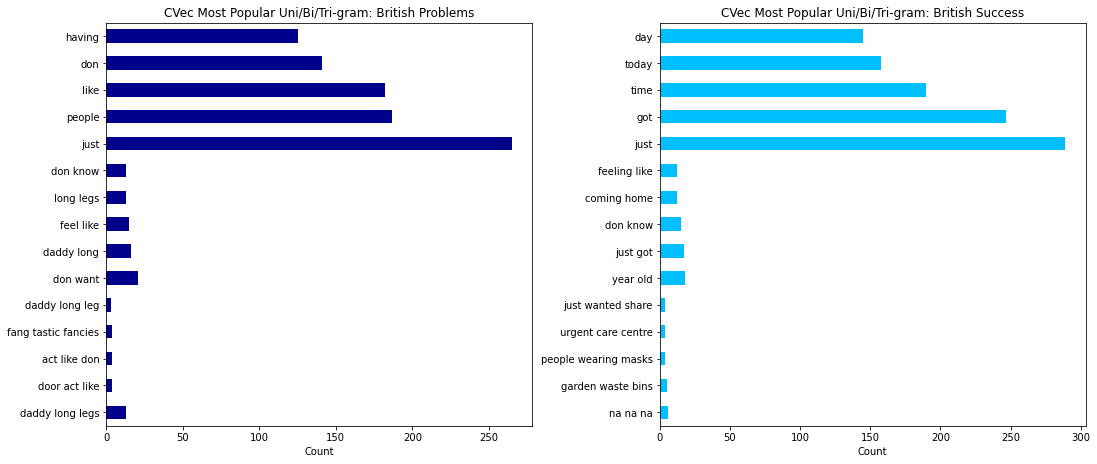

In [50]:
fig = plt.figure(figsize=(17,7))

ax1 = fig.add_subplot(1,2,1)
cvec_problems_combimed_top.plot(kind='barh', color='Darkblue')
ax1.set_title('CVec Most Popular Uni/Bi/Tri-gram: British Problems')
ax1.set_xlabel('Count')

ax2 = fig.add_subplot(1,2,2)
cvec_success_combimed_top .plot(kind='barh', color='deepskyblue')
ax2.set_title('CVec Most Popular Uni/Bi/Tri-gram: British Success')
ax2.set_xlabel('Count');

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)

**Key Observations**
- From the charts, we can see that the word '**just**' is the most commonly used word in both sub-reddits (appeared > 250 times in both sub-reddits). 
- Bigrams associated with '**don't know**' and '**feel like**' are also fairly common in both sub-reddits.
- A couple of bigrams and trigrams in 'British Problems' are interesting - '**daddy long**', '**long legs**', '**daddy long legs**'. These are probably referring to crane flies or commonly known as 'daddy long legs' in UK
- '**coming home**' in 'British Success' is probably related to the famous phrase 'it's coming home' which was especially popular in England's recent success in the Euros 2020 football competition


## Length of Content

The distribution of post length in both sub-reddits are fairly similar - both have a right-skew and most posts are below 100 words. There are more posts in the >100 words category in 'British Success' compared to 'British Problems'.

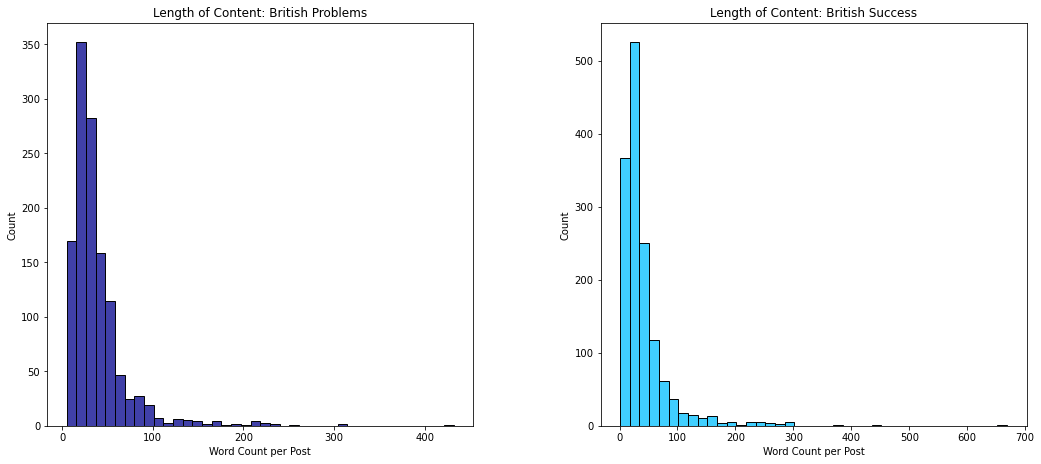

In [51]:
fig = plt.figure(figsize=(17,7))

ax1 = fig.add_subplot(1,2,1)
sns.histplot(problems['word_count'], bins=40, ax=ax1, color='Darkblue')
ax1.set_title('Length of Content: British Problems')
ax1.set_xlabel('Word Count per Post')

ax2 = fig.add_subplot(1,2,2)
sns.histplot(success['word_count'], bins=40, ax=ax2, color='deepskyblue')
ax2.set_title('Length of Content: British Success')
ax2.set_xlabel('Word Count per Post');

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)

## Sentiment Analysis

I also NLTK's SentimentIntensityAnalyzer to perform some preliminary sentiment analysis of each posts in the sub-reddit.

- Both sub-reddits have the most posts around 0 (neutral)
- Although there are more posts in the 'positive' segment for 'British Success' than 'British Problems' (vice versa with 'negative' scores), the mean of sentiment score for 'British Success' is actually slightly below 0 (neutral).

In [52]:
sent = SentimentIntensityAnalyzer()

In [53]:
def sentiment(content):
    '''Function to apply SentimentIntensityAnalyzer'''
    return sent.polarity_scores(content)['compound']

In [54]:
#Sentiment Problems
problems['sentiment'] = problems['content'].apply(sentiment)

#Sentiment Success
success['sentiment'] = success['content'].apply(sentiment)

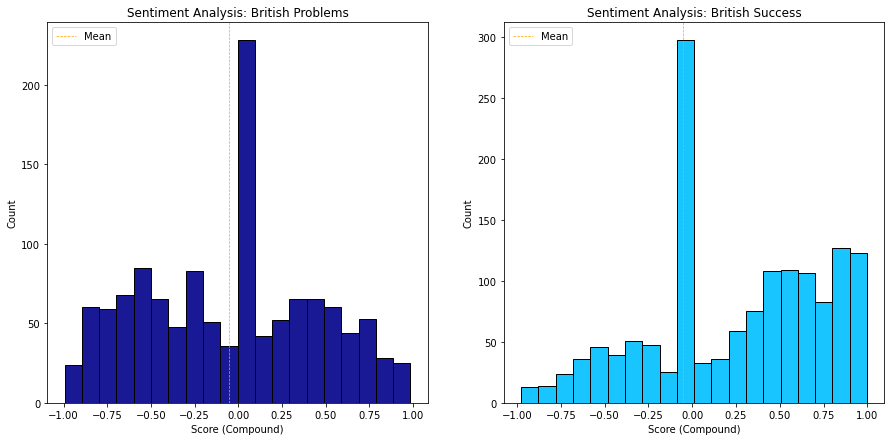

In [55]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1,2,1)
sns.histplot(problems['sentiment'], bins=20, ax=ax1, color='Darkblue', alpha=0.9)
ax1.axvline(problems['sentiment'].mean(), color='orange', label='Mean', linestyle='dashed', linewidth=0.7)
ax1.set_title('Sentiment Analysis: British Problems')
ax1.set_xlabel('Score (Compound)')
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(1,2,2)
sns.histplot(success['sentiment'], bins=20, ax=ax2, color='deepskyblue', alpha=0.9)
ax2.axvline(problems['sentiment'].mean(), color='orange', label='Mean', linestyle='dashed', linewidth=0.7)
ax2.set_title('Sentiment Analysis: British Success')
ax2.set_xlabel('Score (Compound)')
ax2.legend(loc='upper left');

## Popularity of Sub-Reddits

- We sent requests to scrape 2000 posts from each sub-reddit. By checking the most recent and eariest posts from the scrape, we can see that 'British Problems' has the same number of posts within a shorter time period than 'British Success'. 
- This is likely due to 'British Problems' being the more popular sub-reddit with 680k members vs 187k members for 'British Success'

In [56]:
problems['created_utc'] = pd.to_datetime(problems['created_utc'], unit = 's')

In [57]:
success['created_utc'] = pd.to_datetime(success['created_utc'], unit = 's')

In [58]:
print(f'Latest post in problems: ', problems['created_utc'].max())
print(f'Earliest post in problems: ', problems['created_utc'].min())

Latest post in problems:  2021-09-24 01:07:03
Earliest post in problems:  2021-09-09 11:19:10


In [59]:
print(f'Latest post in success: ', success['created_utc'].max())
print(f'Earliest post in success: ', success['created_utc'].min())

Latest post in success:  2021-09-23 20:58:59
Earliest post in success:  2021-04-24 09:00:48


## Authors

There are 94 same authors contributing in both sub-reddits. As a sense check, there are no exact same posts in the sub-reddits (would be an issue if a same post appears on both sub-reddit). I have also briefly read the posts of the top authors in each sub-reddit - their posts in the other sub-reddit are sufficiently distinct from their posts in the sub-reddit where they are the top posters. 

In [60]:
#author comparison
problems_author = set(problems['author'])
success_author = set(success['author'])

In [61]:
len(problems_author.intersection(success_author))

94

In [62]:
#content comparison
problems_content = set(problems['content'])
success_content = set(success['content'])

In [63]:
len(problems_content.intersection(success_content))

0

In [64]:
problems['author'].value_counts().head(5)

Mosquitoenail          11
Iloveshortbreadb        8
No-Economist3226        7
Christopher_2688        7
MuchRatherBeNapping     6
Name: author, dtype: int64

In [65]:
success['author'].value_counts().head(5)

kickypie               25
yeah-go-on-then        22
mynipnops              18
Bikeboy76              15
MuchRatherBeNapping    12
Name: author, dtype: int64

# Export Datasets

Final check on datasets before export

In [66]:
problems.shape

(1241, 7)

In [67]:
success.shape

(1451, 7)

Export Datasets to CSV

In [68]:
problems.to_csv(r'../datasets/clean_problems.csv', index=False)

In [69]:
success.to_csv(r'../datasets/clean_success.csv', index=False)

We will proceed to modelling in the next section.